In [412]:
from captcha.image import ImageCaptcha
from random import sample
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils.np_utils import to_categorical
from keras.layers import Convolution2D, MaxPooling2D, GRU, TimeDistributed
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten, RepeatVector,Input
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential,Model,load_model
from keras.callbacks import ModelCheckpoint, Callback
from keras.optimizers import SGD
import imageio
import glob
import random
import PIL
from keras import backend as K
from PIL import Image
import keras
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [413]:
characters =  list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
#nums = [str(li) for li in range(1,10)]  # 1-9
nums = []
all_chars = characters + nums
char_index = {}
for (idx,ch) in enumerate(all_chars):
    char_index[ch] = idx
print "total chars", len(char_index)

H, W, C = 60, 60, 3
def generate_data(font, total_samples, output_dir, digits_num=3, width=100, height=100, font_sizes=[50]):
    image = ImageCaptcha(fonts=[font], width=width, height=height, font_sizes=font_sizes)
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)    
    labels = []
    total_images = []
    for i in range(total_samples):
        cur_cap = sample(characters, digits_num)
        cur_cap =''.join(cur_cap)
        image.write(cur_cap, output_dir + "images/" + str(i) +".png")
        # resize it and convert to gray scale
        #img = Image.open(output_dir + "images/" + str(i) +".png").convert('L')
        img = Image.open(output_dir + "images/" + str(i) +".png")
        img = img.resize((width, height))
        
        img.save(output_dir + "images/" + str(i) +".png")
        img = imageio.imread(output_dir + "images/" + str(i) +".png")
        total_images.append(np.array(img))
        
        label = []
        for ch in cur_cap:
            label.append(char_index[ch])
        labels.append(label)
    labels = np.asarray(labels)
    labels.dump(output_dir + "labels/" + "labels")
    images = np.asarray(total_images)
    images.dump(output_dir + "images/" + "images")
    
# generate source image        
#generate_data("fonts/font_source/LeagueGothic-Regular.otf", 20000, "sourceImages/")
    
# generate target image
#generate_data("fonts/font_target/OpenSans-Bold.ttf", 15000, "targetImages/")

total chars 52


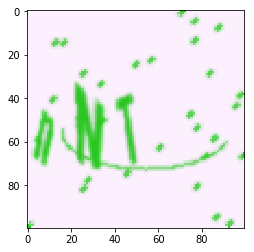

In [414]:
#check source sample
img = mpimg.imread('sourceImages/images/9.png')
plt.imshow(img)
plt.show()

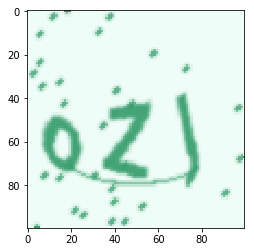

(100, 100, 3)


In [415]:
#check target sample
img = mpimg.imread('targetImages/images/9.png')
plt.imshow(img)
plt.show()
print(img.shape)

In [416]:
# create a function to load all data
def load_data(images_dir, labels_dir, split_ratio):
    
    with open(images_dir, "rb")as f:
        images = np.load(f)

    images = np.asarray(images)
    
    with open(labels_dir, "rb") as f:
        labels = np.load(f)

    vocab_size = len(all_chars)

    labels_categorical = np.asarray([to_categorical(label, vocab_size) for label in labels])
    print "images shape", images.shape
    # print images[0]
    print "input labels shape", labels_categorical.shape
    total = images.shape[0]
    seed = range(total)
    random.shuffle(seed)
    split_index = int(total*split_ratio)
    train_data = images[seed[0:split_index]]
    train_label = labels_categorical[seed[0:split_index]]
    val_data = images[seed[split_index:]]
    val_label = labels_categorical[seed[split_index:]]
    return (train_data, train_label, val_data, val_label)

source_trainX, source_trainY, source_valX, source_valY = load_data("sourceImages/images/images","sourceImages/labels/labels", 0.75)
target_trainX, target_trainY, _, _ = load_data("targetImages/images/images","targetImages/labels/labels", 1)

images shape (20000, 100, 100, 3)
input labels shape (20000, 3, 52)
images shape (15000, 100, 100, 3)
input labels shape (15000, 3, 52)


In [417]:
def create_classifier(vocab_size, num_outputs_chars = 3, image_shape=(100,100,3)):
    '''
    num_outputs_chars: how many output should the model have; we only have one output by default, which means the sequence only has three letters
    '''
    image_model = Sequential()
    image_model.add(Convolution2D(32, (3, 3), padding='valid', input_shape=image_shape))
    image_model.add(BatchNormalization())
    image_model.add(Activation('relu'))
    image_model.add(Convolution2D(32, (3, 3), padding='valid'))
    image_model.add(BatchNormalization())
    image_model.add(Activation('relu'))
    image_model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    image_model.add(Dropout(0.25))
    image_model.add(Convolution2D(64, (3, 3), padding='valid'))
    image_model.add(BatchNormalization())
    image_model.add(Activation('relu'))
    image_model.add(Convolution2D(64, (3, 3),padding='valid'))
    image_model.add(BatchNormalization())
    image_model.add(Activation('relu'))
    image_model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    image_model.add(Dropout(0.25))
    image_model.add(Flatten())
    
    image_model.summary()
    #for layer in image_model.layers:
    #    print(layer.get_output_at(0).get_shape().as_list())
    # Note: Keras does automatic shape inference.
    image_input = Input(shape=image_shape)
    encoded_image = image_model(image_input)

    outputs = []
    for i in range(num_outputs_chars):
        out1 = Dense(128, activation="relu")(encoded_image)
        output1 = Dense(vocab_size, activation="softmax")(out1)
        outputs.append(output1)
    model = Model([image_input], outputs)
    return (model,encoded_image, image_input)
    

In [418]:
source_classifier,_,_= create_classifier(len(all_chars))
print("source_classifier summary")
source_classifier.summary()
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
source_classifier.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
checkpointer= ModelCheckpoint(filepath="sourceModel/weights.{epoch:02d}.hdf5")
# we only use one letter 
digit1 = source_trainY[:,0,:]
digit2 = source_trainY[:,1,:]
digit3 = source_trainY[:,2,:]

val_digit1 = source_valY[:,0,:]
val_digit2 = source_valY[:,1,:]
val_digit3 = source_valY[:,2,:]

source_classifier = load_model("sourceModel/source_model.hdf5")

source_classifier.fit(source_trainX, [digit1, digit2, digit3], validation_data = (source_valX,[val_digit1, val_digit2, val_digit3]), shuffle=True,batch_size=64, epochs=40,callbacks=[checkpointer])
source_classifier.save("sourceModel/source_model.hdf5")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_371 (Conv2D)          (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_370 (Bat (None, 98, 98, 32)        128       
_________________________________________________________________
activation_370 (Activation)  (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_372 (Conv2D)          (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_371 (Bat (None, 96, 96, 32)        128       
_________________________________________________________________
activation_371 (Activation)  (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_185 (MaxPoolin (None, 48, 48, 32)        0         
__________

In [419]:
def predict_on_dataset(model, data, label):
    return model.evaluate(x=data, y=label)
    
# let's see the accuracy of the source classifier on target dataset
target_digit1 = target_trainY[:,0,:]
target_digit2 = target_trainY[:,1,:]
target_digit3 = target_trainY[:,2,:]
# from the above result we can know that the validataion result is best when epoch = 2
source_classifier=load_model("sourceModel/weights.01.hdf5")
print predict_on_dataset(source_classifier, data=target_trainX, label=[target_digit1, target_digit2, target_digit3])
# from the result we can notice that the model predict a bad result on target data


14976/15000 [============================>.] - ETA: 0s[41.00128176066081, 13.186067669677735, 13.313342899576822, 14.501871175130209, 0.040266666666666666, 0.023, 0.021933333333333332]


In [546]:
def domain_classifier(encoded_image_tensor):
    x = Dense(100, activation='relu')(encoded_image_tensor)
    x = Dense(100, activation='relu')(x)
    x = Dense(2, activation = 'sigmoid')(x)
    return x



source_or_target_tensor = Input(shape=(22*22*64,))
discriminator_model = Model(inputs=source_or_target_tensor, output=domain_classifier(source_or_target_tensor), name="discriminator")
print("discriminator model summary")
discriminator_model.summary()
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
discriminator_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
discriminator_model.trainable=False


_,target_image_tensor,image_input = create_classifier(len(all_chars))
#print(keras.backend.shape(target_image_tensor))  # input shape should be inferred from here
target_model = Model(inputs = image_input, outputs=target_image_tensor, name="target_model")
print("target model summary")
target_model.summary()

temp = target_model(image_input)
combined_model = Model(inputs=image_input, outputs=discriminator_model(temp))
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
combined_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print("combined model summary")
combined_model.summary()


/data1/slynedeng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., name="discriminator", inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


discriminator model summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_152 (InputLayer)       (None, 30976)             0         
_________________________________________________________________
dense_654 (Dense)            (None, 100)               3097700   
_________________________________________________________________
dense_655 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_656 (Dense)            (None, 2)                 202       
Total params: 3,108,002
Trainable params: 3,108,002
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_391 (Conv2D)          (None, 98, 98, 32)        896       
______________________________________

In [547]:
source_classifier = load_model("sourceModel/weights.01.hdf5")
for layer in source_classifier.layers:
    layer.trainable = False
source_classifier.summary()

print(source_classifier.layers[1].get_output_at(1))
target_layer = 1
get_source_encode_layer_output = K.function([source_classifier.layers[0].input, K.learning_phase()],
                                  [source_classifier.layers[1].get_output_at(1)])

# output in test mode = 0
# output in train mode = 1
#source_classifier_tensor = get_source_encode_layer_output([x,0])[0]

#source_classifier_tensor = intermediate_layer_model.predict(data)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_101 (InputLayer)           (None, 100, 100, 3)   0                                            
____________________________________________________________________________________________________
sequential_144 (Sequential)      (None, 30976)         66336       input_101[0][0]                  
____________________________________________________________________________________________________
dense_447 (Dense)                (None, 128)           3965056     sequential_144[1][0]             
____________________________________________________________________________________________________
dense_449 (Dense)                (None, 128)           3965056     sequential_144[1][0]             
___________________________________________________________________________________________

In [555]:
# begin to train alternatively
def data_generator(X_train, y_train, batch_size):
    idx = 0
    total = len(X_train)
    while 1:
        p = np.random.permutation(len(X_train)) # shuffle each time
        X_train = X_train[p]
        y_train = y_train[p]
        for i in range(total/batch_size):
            yield X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            
        

source_data_generator = data_generator(source_trainX, source_trainY, 32)
target_data_generator = data_generator(target_trainX, target_trainY, 32)


loss_fake = np.zeros(shape=len(combined_model.metrics_names))
#pretrain

print("begin to pre train")
for i in range(4000):
        sample_target_x, sample_target_y = next(target_data_generator)
        target_y = to_categorical(np.ones(len(sample_target_y)),num_classes=2)
        loss_fake= np.add(combined_model.train_on_batch(sample_target_x, target_y), loss_fake)
        if i % 200 == 0 and i > 0:
            print(loss_fake/200)
            loss_fake = 0
print("finish pretrain")


total_training_steps = 15000/32 * 1
k_d = 1
k_g = 2
loss_fake = np.zeros(shape=len(discriminator_model.metrics_names))
loss_dis = np.zeros(shape=len(discriminator_model.metrics_names))

print(discriminator_model.metrics_names)

for t in range(total_training_steps):    
    for i in range(k_g):
        sample_target_x, sample_target_y = next(target_data_generator)
        target_y = to_categorical(np.ones(len(sample_target_y)),num_classes=2)
        sample_target_x2, sample_target_y = next(target_data_generator)
        target_y2 = to_categorical(np.ones(len(sample_target_y)),num_classes=2)
        combine_x = np.concatenate((sample_target_x, sample_target_x2),axis = 0)
        combine_y = np.concatenate((target_y, target_y2), axis = 0)
        loss_fake= np.add(combined_model.train_on_batch(combine_x, combine_y), loss_fake)
        
        
    for i in range(k_d):
        sample_source_x, sample_source_y = next(source_data_generator)
        sample_target_x, sample_target_y = next(target_data_generator)
        source_y = to_categorical(np.ones(len(sample_source_y)), num_classes=2)
        target_y = to_categorical(np.zeros(len(sample_target_y)), num_classes=2)
        source_tensor_output = get_source_encode_layer_output([sample_source_x,0])[0]
        target_tensor_output = target_model.predict(sample_target_x)
        combine_source_target = np.concatenate((source_tensor_output,target_tensor_output), axis = 0)
        combine_y = np.concatenate((source_y, target_y), axis = 0)
        loss_dis = np.add(discriminator_model.train_on_batch(combine_source_target, combine_y),loss_dis)

                 
    if (t % 10) == 0:
        print "loss fake", loss_fake/(10*k_g)
        print "loss_dis", loss_dis/(10*k_d)

        loss_fake = np.zeros(shape=len(discriminator_model.metrics_names))
        loss_dis= np.zeros(shape=len(discriminator_model.metrics_names))
        
target_model.save("targetModel/target_model.hdf5")
discriminator_model.save("discriminatorModel/discriminator_model.hdf5")

    
    

begin to pre train
[ 0.15035945  0.97421875]
[ 0.04450023  0.99453127]
[ 0.02521302  0.99781251]
[ 0.01872749  0.99921876]
[ 0.01624485  0.99937499]
[ 0.01316375  0.99984378]
[ 0.01151829  0.99953127]
[ 0.01043863  0.99984378]


KeyboardInterrupt: 

In [560]:
source_classifier = load_model("sourceModel/weights.01.hdf5")
data=target_trainX
label=[target_digit1, target_digit2, target_digit3]
target_encoding = target_model.predict(data)
print(target_encoding.shape)

#print(source_classifier.layers)
model = source_classifier
end_classify = K.function([model.layers[2].input,K.learning_phase()],
                                  [model.layers[-3].output, model.layers[-2].output, model.layers[-1].output])

label1_predict= []
label2_predict = []
label3_predict = []
for i in range(len(target_encoding)):
    layer_output1, layer_output2, layer_output3 = end_classify([[target_encoding[i]],0])
    label1_predict.append(np.argmax(layer_output1))
    label2_predict.append(np.argmax(layer_output2))
    label3_predict.append(np.argmax(layer_output3))
    


(15000, 30976)


In [561]:
print(label1_predict[0:20])

[31, 15, 51, 12, 18, 38, 17, 4, 45, 44, 45, 36, 17, 12, 18, 45, 12, 18, 15, 15]


In [562]:
true_label1 = np.argmax(target_digit1,axis=1)
true_label2 = np.argmax(target_digit2, axis=1)
true_label3 = np.argmax(target_digit3, axis = 1)

In [563]:
print (np.sum(label1_predict == true_label1)/float(len(label1_predict)))
print(np.sum(label2_predict == true_label1)/float(len(label2_predict)))
print(np.sum(label3_predict == true_label1)/float(len(label3_predict)))

0.0367333333333
0.062
0.0183333333333
